In [134]:
import numpy as np
import pandas as pd
import math
from haversine import haversine
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

In [135]:
file = '1996-2020_U3.csv'
u1a = '2002-2004_U1a.csv'
u1b = '2002-2004_U1b.csv'
u2a = '2002-2004_U2a.csv'
u2b = '2002-2004_U2b.csv'
u3a = '2002-2004_U3a.csv'
u3b = '2002-2004_U3b.csv'
u4a = '2002-2004_U4a.csv'
u4b = '2002-2004_U4b.csv'
u5a = '2002-2004_U5a.csv'
f_station = '2002-2004_station.csv'

df = pd.read_csv(file, encoding='cp949')
df_u1a = pd.read_csv(u1a, encoding='cp949')
df_u1b = pd.read_csv(u1b, encoding='cp949')
df_u2a = pd.read_csv(u2a, encoding='cp949')
df_u2b = pd.read_csv(u2b, encoding='cp949')
df_u3a = pd.read_csv(u3a, encoding='cp949')
df_u3b = pd.read_csv(u3b, encoding='cp949') #결측값이 많음
df_u4a = pd.read_csv(u4a, encoding='cp949')
df_u4b = pd.read_csv(u4b, encoding='cp949')
df_u5a = pd.read_csv(u5a, encoding='cp949')
station = pd.read_csv(f_station, encoding='cp949')

global u3_lon
global u3_lat
global sta_lon
global sta_lat
global p # IDW 변수

sta_lon = list(station.iloc[:, 1])
sta_lat = list(station.iloc[:, 2])
u3_lon = sta_lon[2]
u3_lat = sta_lat[2]
p = 1


file_list = [df, df_u1a, df_u1b, df_u2a, df_u2b, df_u3a, df_u3b, df_u4a, df_u4b, df_u5a]
str_list = ['df', 'df_u1a', 'df_u1b', 'df_u2a', 'df_u2b', 'df_u3a', 'df_u3b', 'df_u4a', 'df_u4b', 'df_u5a']

#날짜 형식으로 변환 후 지점별 번호 부여
for i, j in zip(file_list, str_list):
    pd.set_option('mode.chained_assignment', None)
    for k in range(len(i)):
        if (i['Month'][k] < 10) == True:
            i['Month'][k] = '0' + str(i['Month'][k])

    date = i['Year'].astype(str) + i['Month'].astype(str) + i['Day'].astype(str)
    i.insert(0, 'Date', date)
    i['Date'] = pd.to_datetime(i['Date'],format='%Y%m%d', errors='raise')

    if (j == 'df_u1a') or (j == 'df_u1b'):
        i.insert(5, 'Station', 0)
    elif (j == 'df_u2a') or (j == 'df_u2b'):
        i.insert(5, 'Station', 1)
    elif (j == 'df_u3a') or (j == 'df_u3b'):
        i.insert(5, 'Station', 2)
    elif (j == 'df_u4a') or (j == 'df_u4b'):
        i.insert(5, 'Station', 3)
    elif (j == 'df_u5a'):
        i.insert(5, 'Station', 4)


drop_col = ['Year', 'Month', 'Day', 'Minute', 'Second']
for j in file_list:
    j.drop(drop_col, axis=1, inplace=True)

In [136]:
def get_distance_weight(df):
    z1 = 1800
    z2 = int(df.iloc[0]['Depth (meter)'])
    z_dist = abs(z2 - z1) / 1000

    for i in range(len(sta_lon)):
        if df['Station'][0] == i:
            lon = sta_lon[i]
            lat = sta_lat[i]

    point = (lat, lon)
    u3_point = (u3_lat, u3_lon)
    xy_dist = haversine(point, u3_point, unit='km')

    dist = math.sqrt(pow(xy_dist, 2) + pow(z_dist, 2))
    weight = 1 / pow(dist, p) # 역거리 가중치

    return dist, weight

In [137]:
dist_list = []
weight_list = []
file_list = [df_u1a, df_u1b, df_u2a, df_u2b, df_u3a, df_u3b, df_u4a, df_u4b, df_u5a]
for i in file_list:
    distance, weight = get_distance_weight(i)
    dist_list.append(distance)
    weight_list.append(weight)

weight_list

[0.03376592317925071,
 0.033764335257122885,
 0.06409790804348081,
 0.06407137894982544,
 9.090909090909092,
 2.272727272727273,
 0.048866803338629555,
 0.04886059649686619,
 0.03877227898699145]

In [138]:
start_date = datetime.strptime('2002-11-28 14', '%Y-%m-%d %H')
end_date = datetime.strptime('2004-04-07 13', '%Y-%m-%d %H')
z = pd.DataFrame(columns=['Date', 'Hour', 'Ur Current speed (cm/s)'])
while start_date <= end_date:
    date = start_date.strftime('%Y-%m-%d')
    hour = start_date.hour

    den_list = [] # 분모
    num_list = [] # 분자
    for i in range(len(file_list)):
        cond = (file_list[i]['Date'] == date) & (file_list[i]['Hour'] == hour)

        for j in range(0,9):
            if (i == j) & (cond.any() == True):
                den_list.append(weight_list[j])
                num_list.append(weight_list[j] * file_list[i][cond]['Ur Current speed (cm/s)'].values)

    inter = sum(num_list) / sum(den_list) # IDW 적용된 값

    temp_df = {'Date': date, 'Hour': hour, 'Ur Current speed (cm/s)': inter}
    temp_df = pd.DataFrame(temp_df)
    z = pd.concat([z, temp_df])

    print(start_date)
    start_date += timedelta(hours=1)


print(z)

2002-11-28 14:00:00
2002-11-28 15:00:00
2002-11-28 16:00:00
2002-11-28 17:00:00
2002-11-28 18:00:00
2002-11-28 19:00:00
2002-11-28 20:00:00
2002-11-28 21:00:00
2002-11-28 22:00:00
2002-11-28 23:00:00
2002-11-29 00:00:00
2002-11-29 01:00:00
2002-11-29 02:00:00
2002-11-29 03:00:00
2002-11-29 04:00:00
2002-11-29 05:00:00
2002-11-29 06:00:00
2002-11-29 07:00:00
2002-11-29 08:00:00
2002-11-29 09:00:00
2002-11-29 10:00:00
2002-11-29 11:00:00
2002-11-29 12:00:00
2002-11-29 13:00:00
2002-11-29 14:00:00
2002-11-29 15:00:00
2002-11-29 16:00:00
2002-11-29 17:00:00
2002-11-29 18:00:00
2002-11-29 19:00:00
2002-11-29 20:00:00
2002-11-29 21:00:00
2002-11-29 22:00:00
2002-11-29 23:00:00
2002-11-30 00:00:00
2002-11-30 01:00:00
2002-11-30 02:00:00
2002-11-30 03:00:00
2002-11-30 04:00:00
2002-11-30 05:00:00
2002-11-30 06:00:00
2002-11-30 07:00:00
2002-11-30 08:00:00
2002-11-30 09:00:00
2002-11-30 10:00:00
2002-11-30 11:00:00
2002-11-30 12:00:00
2002-11-30 13:00:00
2002-11-30 14:00:00
2002-11-30 15:00:00


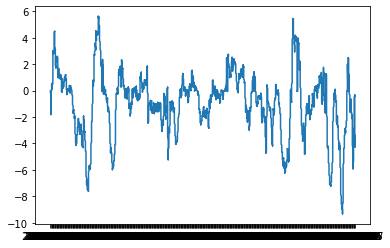

In [139]:
plt.plot(z['Date'], z['Ur Current speed (cm/s)'])
plt.show()

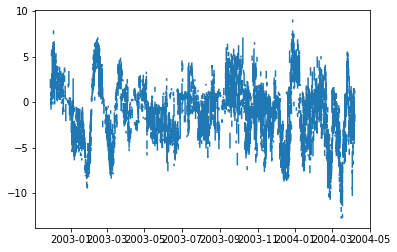

In [140]:
df_filtered = df[df['Date'].isin(pd.date_range('2002-11-28', '2004-04-07'))]
df_filtered = df_filtered.iloc[14:-10]
plt.plot(df_filtered['Date'], df_filtered['Ur Current speed (cm/s)'])
plt.show()

In [141]:
df_1800 = df_filtered.copy()
df_1800.reset_index(inplace=True, drop=True)
inter_list = z['Ur Current speed (cm/s)'].to_list()
df_1800['Inter'] = inter_list

for i in range(len(df_1800)):
    df_1800['Ur Current speed (cm/s)'] = df_1800['Ur Current speed (cm/s)'].replace(np.nan, df_1800['Inter'][i])

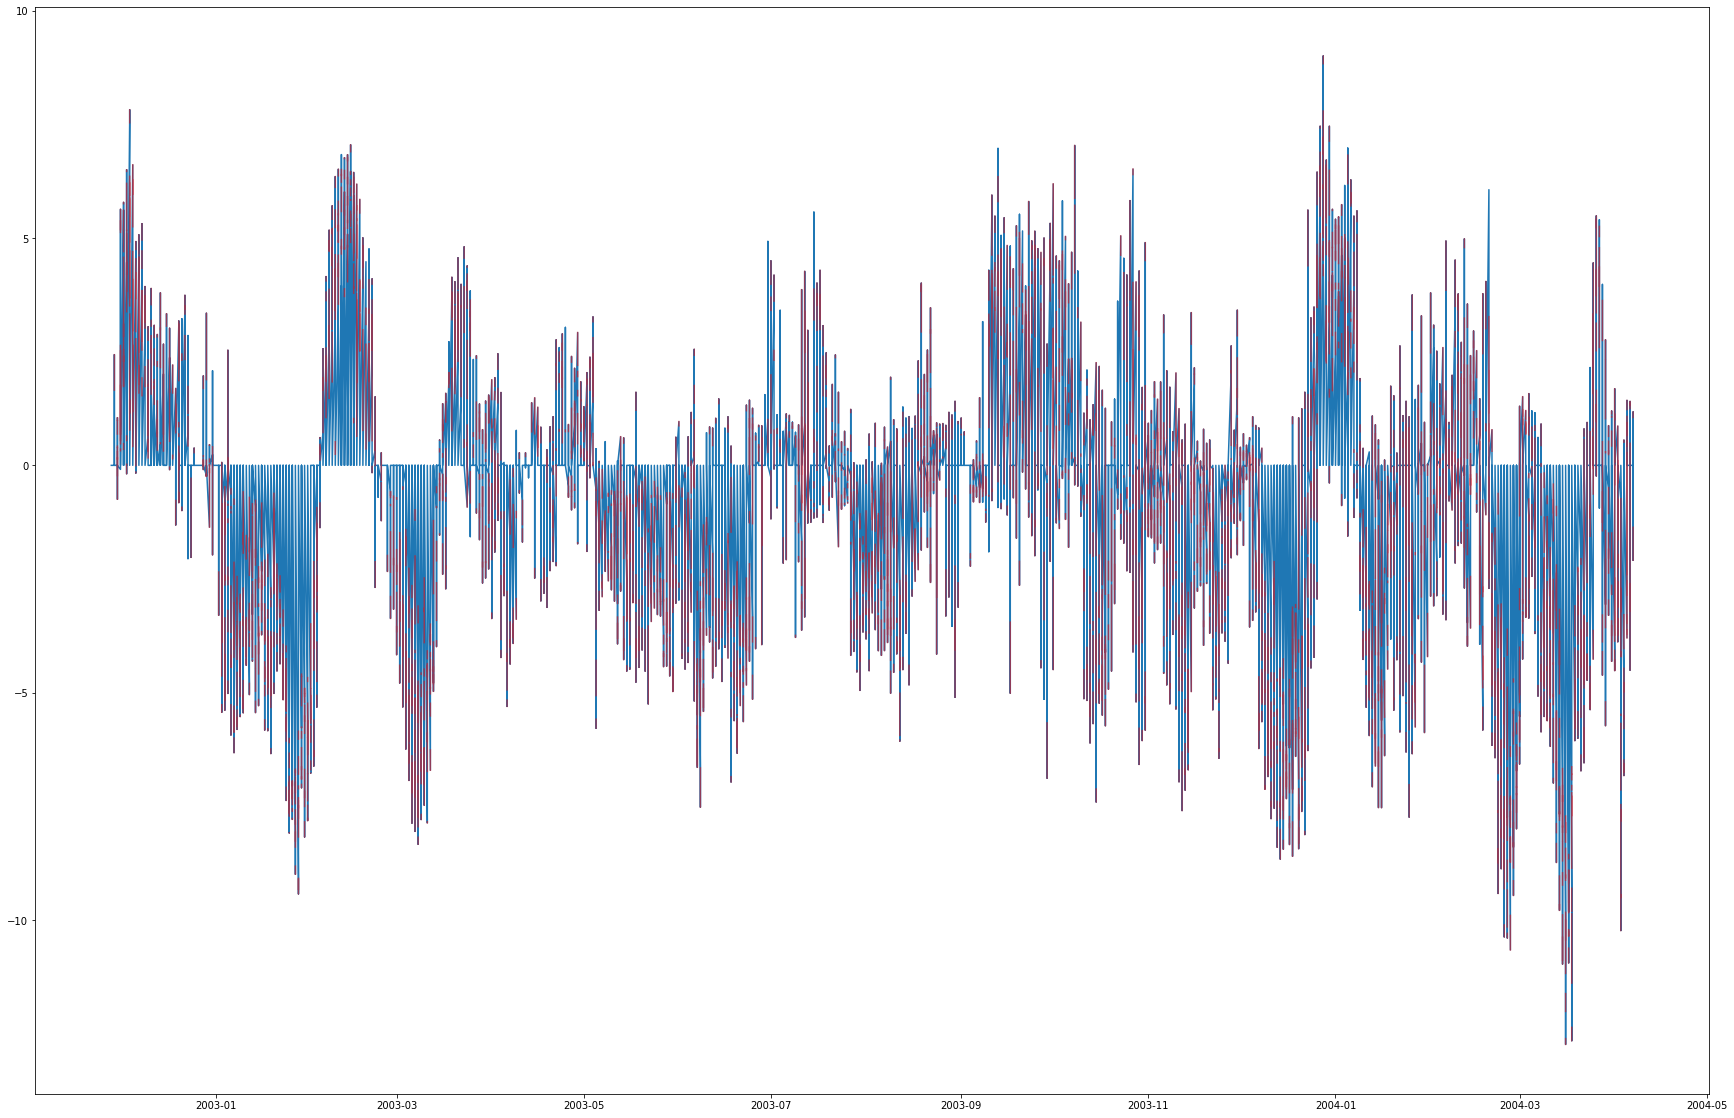

In [142]:
plt.figure(figsize=(30,20))
plt.plot(df_1800['Date'], df_1800['Ur Current speed (cm/s)'])
plt.plot(df_filtered['Date'], df_filtered['Ur Current speed (cm/s)'], alpha=0.5, color='red')
plt.show()

In [143]:
df_1800.drop(['Station', 'Inter'], axis=1, inplace=True)
df_1800

,Date,Hour,Depth (meter),Ur Current speed (cm/s)
0,2002-11-28,14,1800,-0.000014
1,2002-11-28,15,1800,-0.000014
2,2002-11-28,16,1800,-0.000014
3,2002-11-28,17,1800,-0.000014
4,2002-11-28,18,1800,-0.000014
...,...,...,...,...
11899,2004-04-07,9,1800,-1.362262
11900,2004-04-07,10,1800,-2.087719
11901,2004-04-07,11,1800,-0.000014
11902,2004-04-07,12,1800,-0.000014


In [150]:
depth_3a = df_u3a['Depth (meter)'][0]
depth_3b = df_u3b['Depth (meter)'][0]
depth_1800 = df_1800['Depth (meter)'][0]

def get_weight(depth):
    dist = abs(depth - 1500) / 1000
    weight = 1 / pow(dist, p)

    return weight

weight = []
weight.append(get_weight(depth_3a))
weight.append(get_weight(depth_3b))
weight.append(get_weight(depth_1800))

weight

[5.2631578947368425, 1.3513513513513513, 3.3333333333333335]

In [154]:
start_date = datetime.strptime('2002-11-30 11', '%Y-%m-%d %H')
end_date = datetime.strptime('2004-04-07 11', '%Y-%m-%d %H')
df_1500 = pd.DataFrame(columns=['Date', 'Hour', 'Ur Current speed (cm/s)'])
file_list = [df_u1a, df_u1b, df_1800]
while start_date <= end_date:
    date = start_date.strftime('%Y-%m-%d')
    hour = start_date.hour

    den_list = [] # 분모
    num_list = [] # 분자
    for i in range(len(file_list)):
        cond = (file_list[i]['Date'] == date) & (file_list[i]['Hour'] == hour)

        for j in range(0,3):
            if (i == j) & (cond.any() == True):
                den_list.append(weight_list[j])
                num_list.append(weight_list[j] * file_list[i][cond]['Ur Current speed (cm/s)'].values)

    inter = sum(num_list) / sum(den_list) # IDW 적용된 값

    temp_df = {'Date': date, 'Hour': hour, 'Ur Current speed (cm/s)': inter}
    temp_df = pd.DataFrame(temp_df)
    df_1500 = pd.concat([df_1500, temp_df])

    print(start_date)
    start_date += timedelta(hours=1)

2002-11-30 11:00:00
2002-11-30 12:00:00
2002-11-30 13:00:00
2002-11-30 14:00:00
2002-11-30 15:00:00
2002-11-30 16:00:00
2002-11-30 17:00:00
2002-11-30 18:00:00
2002-11-30 19:00:00
2002-11-30 20:00:00
2002-11-30 21:00:00
2002-11-30 22:00:00
2002-11-30 23:00:00
2002-12-01 00:00:00
2002-12-01 01:00:00
2002-12-01 02:00:00
2002-12-01 03:00:00
2002-12-01 04:00:00
2002-12-01 05:00:00
2002-12-01 06:00:00
2002-12-01 07:00:00
2002-12-01 08:00:00
2002-12-01 09:00:00
2002-12-01 10:00:00
2002-12-01 11:00:00
2002-12-01 12:00:00
2002-12-01 13:00:00
2002-12-01 14:00:00
2002-12-01 15:00:00
2002-12-01 16:00:00
2002-12-01 17:00:00
2002-12-01 18:00:00
2002-12-01 19:00:00
2002-12-01 20:00:00
2002-12-01 21:00:00
2002-12-01 22:00:00
2002-12-01 23:00:00
2002-12-02 00:00:00
2002-12-02 01:00:00
2002-12-02 02:00:00
2002-12-02 03:00:00
2002-12-02 04:00:00
2002-12-02 05:00:00
2002-12-02 06:00:00
2002-12-02 07:00:00
2002-12-02 08:00:00
2002-12-02 09:00:00
2002-12-02 10:00:00
2002-12-02 11:00:00
2002-12-02 12:00:00


,Date,Hour,Ur Current speed (cm/s)
0,2002-11-30,11,-0.000005
0,2002-11-30,12,0.192932
0,2002-11-30,13,0.205967
0,2002-11-30,14,0.000159
0,2002-11-30,15,0.145936
...,...,...,...
0,2004-04-07,7,-0.476146
0,2004-04-07,8,-1.121245
0,2004-04-07,9,-1.845415
0,2004-04-07,10,-2.246792


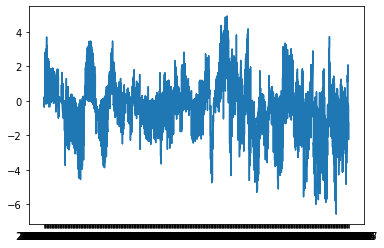

In [159]:
plt.plot(df_1500['Date'], df_1500['Ur Current speed (cm/s)'])
plt.show()

In [158]:
df_1500.to_csv('D:/JOISS/u3_1500.csv', index=False)